In [12]:
import pandas as pd
import numpy as np
import pickle
import time 
import os
from datetime import datetime
from operator import itemgetter
import time

# 需要什么读取什么不要一次性全都读取了，影响程序速度

data_folder_path = '../'
raw_data_path = "../raw_data"
storage_path = "../database_storage"
daily_path = "../daily"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")
DCBS_path = os.path.join(storage_path, "DCBS.pkl")

with open('database_ByZCG\\DCBS_DataFrame.pkl', 'rb') as f: 
    DCBS_DataFrame = pickle.load(f)
    
with open('database_ByZCG\\DTBS_DataFrame.pkl', 'rb') as f:  
    DTBS_DataFrame = pickle.load(f)

# 只提取A区中存活的转债的时间序列信息
A_DF = DTBS_DataFrame['A']
A_DF = A_DF[A_DF['ia']==1].copy()

C_DF = DTBS_DataFrame['C'].copy()
D_DF = DTBS_DataFrame['D'].copy()

# 计算所有转债每天的涨跌幅，并找出涨幅大于前N个交易日的q分位数涨跌幅的均值的转债

In [13]:
# ----------------------------------------------------------------------------------------------------------------------
# 下面这些代码的核心功能是回测    ->    利用上面生成的持仓表去实现换仓，计算收益等各类指标
# ----------------------------------------------------------------------------------------------------------------------


# 回测(这是简易版的不考虑持仓情况，姚芊芊需要的算法)，可以修改持仓EXCEL表格
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt,log
from numpy import std

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题


# -------------------------------------------------------------------------------------------------------------------------------------------
# 下面的三个函数是真正实现回测功能的    ->   理论上只要传入合适的参数，可以重复使用，对于不同的策略都不需要修改 
# -------------------------------------------------------------------------------------------------------------------------------------------


# 获取一段时间内等转债份额买入的收益率
def get_period_profit(trade_dates_list, my_position, A_DF):
    profit = []
    for trade_date_index in range(1,len(trade_dates_list)):    
        trade_date = trade_dates_list[trade_date_index]
        last_trade_date = trade_dates_list[trade_date_index-1]

        # 本周期内持有的转债代码，应该是上周期末时换仓买入并持有到本周期末
        codes_list = my_position[last_trade_date]
        if codes_list == []:
            
            profit.append(0)
        else:    
            last_trade_date_all_bond_price_list = list(A_DF.loc[(A_DF.bond_code.isin(codes_list)) & (A_DF['date'] == last_trade_date),'dp'])
            last_trade_date_all_bond_price_sum = sum(last_trade_date_all_bond_price_list)

            trade_date_all_bond_price_list = list(A_DF.loc[(A_DF.bond_code.isin(codes_list)) & (A_DF['date'] == trade_date),'dp'])
            trade_date_all_bond_price_sum = sum(trade_date_all_bond_price_list)

            profit.append(trade_date_all_bond_price_sum / last_trade_date_all_bond_price_sum - 1)
            
    return(profit)


def display(profit, trade_dates_list, C_DF, photo_title, tick_spacing = 10):
    
    # x轴
    x = trade_dates_list[1:]
    
    # 图片名
    photo_title = trade_dates_list[0] + ' 至 ' + trade_dates_list[-1] + '  ' + photo_title
    
    # 获取中证转债指数列表
    zi_df = C_DF[C_DF['date'].isin(trade_dates_list)][['date','zi']].copy()
    zi_df.sort_values('date', ascending=True, inplace=True)
    zi = list(zi_df['zi'])    
    zi_cumulative_return = [zi[index]/zi[0] - 1 for index in range(1, len(zi))]
    zi_weekly_return = [zi[index]/zi[index-1] - 1 for index in range(1,len(zi))]
    
    # 获取累计收益率
    weekly_return = profit
    cumulative_return = []
    
    cr = 1
    for i in profit:
        cr = cr * (i + 1)
        cumulative_return.append(cr - 1)
        
    print('单周收益率：', weekly_return, '\n', '累积收益率：',cumulative_return, 
          '\n用累加算法算出的策略累计收益率：',sum(weekly_return), '\n用累加算法算出的中证转债累计收益率：', sum(zi_weekly_return))
    
    # 绘制累计净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, cumulative_return, color='red', label="策略累计净收益率",linewidth=1)
    plt.plot(x, zi_cumulative_return, color='green', label="中证转债累计净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("累计收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()
    
    # 绘制单周净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, weekly_return, color='red', label="策略单周净收益率",linewidth=1)
    plt.plot(x, zi_weekly_return, color='green', label="中证转债单周净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("单周收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()
    
    return weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return

def get_all_profit(profit, trade_dates_list, C_DF , photo_title, tick_spacing = 10):
    """这个函数就是display函数的简化版，去除了绘图功能"""
    # x轴
    x = trade_dates_list[1:]
        
    # 获取中证转债指数列表
    zi_df = C_DF[C_DF['date'].isin(trade_dates_list)][['date','zi']].copy()
    zi_df.sort_values('date', ascending=True, inplace=True)
    zi = list(zi_df['zi'])    
    zi_cumulative_return = [zi[index]/zi[0] - 1 for index in range(1, len(zi))]
    zi_weekly_return = [zi[index]/zi[index-1] - 1 for index in range(1,len(zi))]
    
    # 获取累计收益率
    weekly_return = profit
    cumulative_return = []
    
    cr = 1
    for i in profit:
        cr = cr * (i + 1)
        cumulative_return.append(cr - 1)
        
    return weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return

def calculate_indicators(trade_dates_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return):
    # 用于获取各类指标
    
    # 周期
    print('周期：', trade_dates_list[0], '至', trade_dates_list[-1])
        
    # 获取策略累计收益率 my_cumulative_return
    my_cumulative_return = cumulative_return[-1]
    print(f'策略累计收益率：{round(my_cumulative_return * 100, 2)}%')
    
    # 获取中证转债累计收益率 zzzz_cumulative_return
    zzzz_cumulative_return = zi_cumulative_return[-1]
    print(f'中证转债累计收益率：{round(zzzz_cumulative_return * 100,2)}%')
    
    # 统计胜率1（收益率大于0的比例）,统计的时候应该去除收益率列表中的0值再进行计算，因为那些周期内没有合适的转债买入因此我们选择空仓
    win_rate_one = len([i for i in weekly_return if i > 0]) / len([i for i in weekly_return if i != 0])
    print(f'胜率1（收益率大于0的比例）：{round(win_rate_one * 100, 2)}%')
    
    # 统计胜率2（收益率高于中证转债指数的比例）,统计的时候应该去除收益率列表中的0值再进行计算，因为那些周期内没有合适的转债买入因此我们选择空仓
    win_rate_two = len([i for i in range(len(weekly_return)) if (weekly_return[i] > zi_weekly_return[i]) & (weekly_return[i] != 0)]) / len([i for i in weekly_return if i != 0])
    print(f'胜率2（收益率高于中证转债指数的比例）：{round(win_rate_two * 100, 2)}%')
    
    # 年化夏普比率，下面这三个的算法不确定，需要确认
    # rf为无风险收益率（10年期国债，暂时取2.684%，这个需要随着时间改动）
    rf = 0.027 / 52    
    avg_rate = np.mean(weekly_return)
    std_rate = np.std(weekly_return)
    sharp_ratio = ((avg_rate - rf) / std_rate) * sqrt(52)
    print(f'夏普比率：{round(sharp_ratio,2)}')
    
    
    # 最大回撤 max_drawdown
    max_drawdown = 0
    cumulative_return_list = list(cumulative_return)
    cumulative_return_list.insert(0,0)
    for i in range(1,len(cumulative_return_list)):
        temp = (max(cumulative_return_list[0:i]) - cumulative_return_list[i])/(1 + max(cumulative_return_list[0:i]))
        if max_drawdown < temp:
            max_drawdown = temp                
    print(f'最大回撤：{round(max_drawdown * 100, 2)}%')
    
    # 年化波动率
    log_return_list = [log(i+1) for i in weekly_return]
    Volatility = std(log_return_list) / sqrt(5)
    annualVolatility = Volatility * sqrt(252) 
    print(f'年化波动率：{round(annualVolatility * 100, 2)}%')
    
    
    
    # 收益最好的一周
    print('收益率最好的一周：',trade_dates_list[weekly_return.index(max(weekly_return))],'至',trade_dates_list[weekly_return.index(max(weekly_return)) + 1])
    
    # 最高单周收益率
    print(f'最高单周收益率：{round(max(weekly_return)*100, 2)}%')
    
    # 收益最差的一周
    print('收益率最差的一周：',trade_dates_list[weekly_return.index(min(weekly_return))],'至',trade_dates_list[weekly_return.index(min(weekly_return)) + 1])
    
    # 最低单周收益率
    print(f'最低单周收益率：{round(min(weekly_return)*100, 2)}%')


# 这个函数的功能是用于绘制不同策略收益对比图
def display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = '各策略累计收益对比图', tick_spacing = 10):    
    # x轴
    x = trade_dates_list[1:]
           
    # 绘制累计净收益率曲线图
    plt.figure(figsize=(40,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    
    plt.plot(x, zi_cumulative_return, label="中证转债",linewidth=1)
    
    for name,my_dict in profit_dict.items():
        my_weekly_return = my_dict['weekly_return']
        my_cumulative_return = my_dict['cumulative_return']
        plt.plot(x, my_cumulative_return, label = name,linewidth=1)
        
    plt.xlabel("时间")
    plt.ylabel("累计收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    
    # 调整绘图区边距，确保图例和刻度完整显示
    plt.subplots_adjust(right=0.8,bottom=0.25)
    
    plt.savefig('result_photo\\各策略累计收益对比图.png')
    # 显示图像
    plt.show()
    
    # 绘制单周净收益率曲线图
    plt.figure(figsize=(40,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    
    plt.plot(x, zi_weekly_return, label="中证转债",linewidth=1)
    for name,my_dict in profit_dict.items():
        my_weekly_return = my_dict['weekly_return']
        my_cumulative_return = my_dict['cumulative_return']
        plt.plot(x, my_weekly_return, label = name,linewidth=1)
    
    plt.xlabel("时间")
    plt.ylabel("单周收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    
    # 调整绘图区边距，确保图例和刻度完整显示
    plt.subplots_adjust(right=0.8,bottom=0.25)
    
    plt.savefig('result_photo\\各策略单周收益对比图.png')
    # 显示图像
    plt.show()

In [22]:
# -------------------------------------------------------------------------------------------------------------------------------------------
# 下面都是准备工作    ->    核心功能是生成：理论的持仓字典my_position（Key是日期，Value是转债代码的列表）、trade_dates_list（交易日期的列表）
# -------------------------------------------------------------------------------------------------------------------------------------------

"""
原始的条件，留个备份
drop_st_my_position_df = drop_st_my_position_df[(drop_st_my_position_df['剩余期限（年）'] >= 0.5) & 
                                                (110 <= drop_st_my_position_df['价格（收盘价全价）']) & 
                                                (drop_st_my_position_df['价格（收盘价全价）'] <= 135) &
                                                (drop_st_my_position_df['债券余额（亿）'] <= 7) &
                                                (drop_st_my_position_df['转股溢价率'] >= 0.05) & 
                                                (drop_st_my_position_df['涨跌幅'] <= 0.02) &
                                                (0 <= drop_st_my_position_df['涨跌幅'])
                                                ].copy()
"""

my_position_df = pd.read_excel('pre_data_for_backtest\\热门可转债+双低（全量数据DTBS，预处理）.xlsx')

# 删除掉ST和*ST股的持仓，
drop_st_my_position_df = my_position_df[~my_position_df['正股名称'].str.contains("ST")]

# 剔除掉剩余期限过短的转债，根据其他条件筛选掉一些转债
drop_st_my_position_df = drop_st_my_position_df[(drop_st_my_position_df['剩余期限（年）'] >= 1) & 
                                                (115 <= drop_st_my_position_df['价格（收盘价全价）']) & 
                                                (drop_st_my_position_df['价格（收盘价全价）'] <= 135) &
                                                (drop_st_my_position_df['债券余额（亿）'] <= 7) &                                                
                                                (drop_st_my_position_df['转股溢价率'] >= 5) & 
                                                (drop_st_my_position_df['涨跌幅'] <= 0.02)
                                                ].copy()

drop_st_my_position_df.to_excel('pre_data_for_backtest\\热门可转债+双低（全量数据DTBS，用于回测）.xlsx',index=False)

In [14]:
def get_my_position(name, start_day, end_day, which_day, D_DF):
    """这个函数的功能是从持仓表中获得标准化的持仓字典，将数据进一步标准化"""
    my_position_df = pd.read_excel('pre_data_for_backtest\\'+ name)
    
    # trade_dates_list 设置调仓日期固定为每周几
    trade_dates_list = list(D_DF.loc[(D_DF['date'] >= start_day)&(D_DF['date'] <= end_day)&(D_DF['which_day'] == which_day), 'date'])
    
    my_position = {date : list(my_position_df.loc[my_position_df['日期'] == date,'可转债代码']) for date in  trade_dates_list}
    
    return my_position, trade_dates_list

{'2022-11-01': [], '2022-11-02': [], '2022-11-03': [], '2022-11-04': [], '2022-11-07': [], '2022-11-08': [], '2022-11-09': [], '2022-11-10': [], '2022-11-11': [], '2022-11-14': [], '2022-11-15': [], '2022-11-16': [], '2022-11-17': [], '2022-11-18': [], '2022-11-21': ['113610.SH'], '2022-11-22': ['113610.SH'], '2022-11-23': [], '2022-11-24': [], '2022-11-25': [], '2022-11-28': [], '2022-11-29': [], '2022-11-30': [], '2022-12-01': [], '2022-12-02': [], '2022-12-05': [], '2022-12-06': [], '2022-12-07': [], '2022-12-08': [], '2022-12-09': [], '2022-12-12': [], '2022-12-13': [], '2022-12-14': [], '2022-12-15': [], '2022-12-16': [], '2022-12-19': ['113643.SH'], '2022-12-20': ['113643.SH', '127062.SZ'], '2022-12-21': ['127062.SZ'], '2022-12-22': ['113643.SH'], '2022-12-23': ['127062.SZ'], '2022-12-26': [], '2022-12-27': [], '2022-12-28': [], '2022-12-29': [], '2022-12-30': []} ['2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10', '202

<Figure size 36000x18000 with 0 Axes>

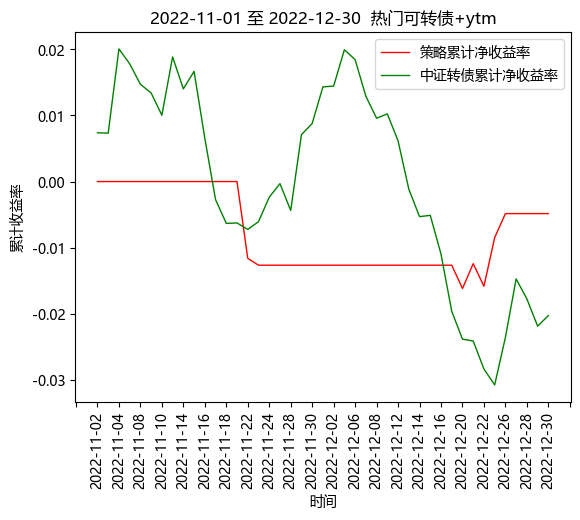

<Figure size 36000x18000 with 0 Axes>

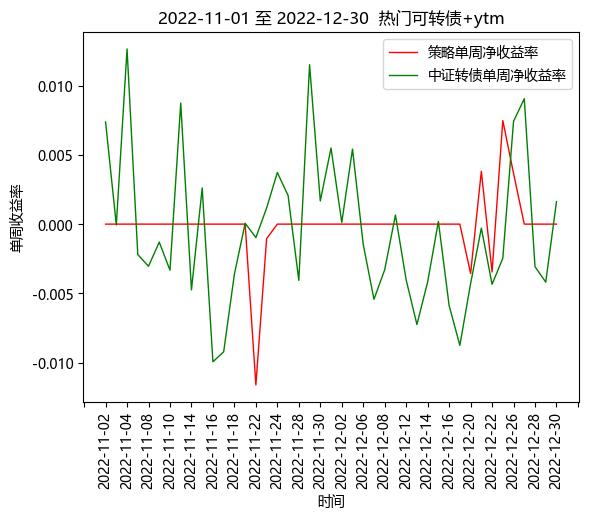

In [8]:
# 2023-08-21 临时需求
# 这里是按日买卖，所以计算的各项指标的函数不能用了

def get_my_position_temp(name, start_day, end_day, which_day, D_DF):
    """这个函数的功能是从持仓表中获得标准化的持仓字典，将数据进一步标准化"""
    my_position_df = pd.read_excel('pre_data_for_backtest\\'+ name)
    
    # trade_dates_list 设置调仓日期固定为每周几
    trade_dates_list = list(D_DF.loc[(D_DF['date'] >= start_day)&(D_DF['date'] <= end_day), 'date'])
    
    my_position = {date : list(my_position_df.loc[my_position_df['日期'] == date,'可转债代码']) for date in  trade_dates_list}
    
    return my_position, trade_dates_list


# 回测单个策略（这样速度更快）
names_and_which_day = [('热门可转债+ytm（全量数据DTBS，用于回测）.xlsx','mon')]
test_day_list = [('2022-11-01','2022-12-31')]

for start_day,end_day in test_day_list: 
    for name,which_day in names_and_which_day: 
        """两层循环是为了实现一次性回测多个策略与多个周期"""
        
        # 获得标准化持仓字典        
        my_position,trade_dates_list = get_my_position_temp(name, start_day, end_day, which_day, D_DF)
        print(my_position,trade_dates_list)
        
        # -------------------------------------------------------------------------------------------------------------------------------------------
        # 直接调用已经定义好的3个函数，传入理论的持仓字典my_position（Key是日期，Value是转债代码的列表）、trade_dates_list（交易日期的列表）
        # -------------------------------------------------------------------------------------------------------------------------------------------

        # 获得收益率曲线列表    
        profit = get_period_profit(trade_dates_list, my_position, A_DF)

        # 调用画图函数，更改tick_spacing的值可以调整打印密度
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = display(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 2)
        
        # 计算各类指标
        # calculate_indicators(trade_dates_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return)

# 2023-08-21 临时需求

单周收益率： [0.03365534378291746, 0.007475733475694746, 0.010939789022196944, 0.007012783123573785, 0.015409584216923733, -0.004427064635493916, -0.00246044965408565, 0.0030586947422648336, -0.004124325599576983, 0.015429404214912568, -0.001154200083465673, 0.004430772504033564, -0.004938477851003431, 0.010019950467804017, -0.033062836673450335, 0.01198442823060386, 0.003919937197454093, 0.005473021723445326, 0.0021483974726370647, 0.006424086856984257, 0.01051635839472187, 0.0010988009485111139, -0.0017647934700949497, 0.01226889411396126, 0.009817768845374442, 0.001403335409171813, 0.012111731768964074, 0.003421218480120336, -0.011238222632893202, -0.006768842529689678, -0.005333373955667575, 0.005376158088108207] 
 累积收益率： [0.03365534378291746, 0.041382675638766075, 0.052775182401625154, 0.060158066433688484, 0.07649466144164951, 0.07172894999568324, 0.06909201487139272, 0.07236204099627708, 0.06793927077858153, 0.08441693746440326, 0.0831653033446702, 0.08796456238805295, 0.0825916734940

<Figure size 36000x18000 with 0 Axes>

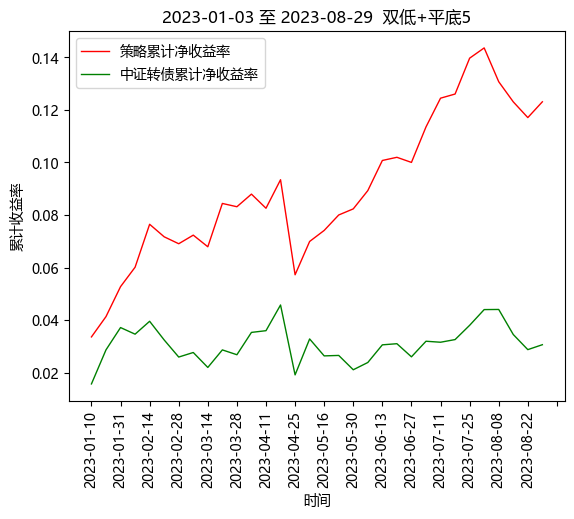

<Figure size 36000x18000 with 0 Axes>

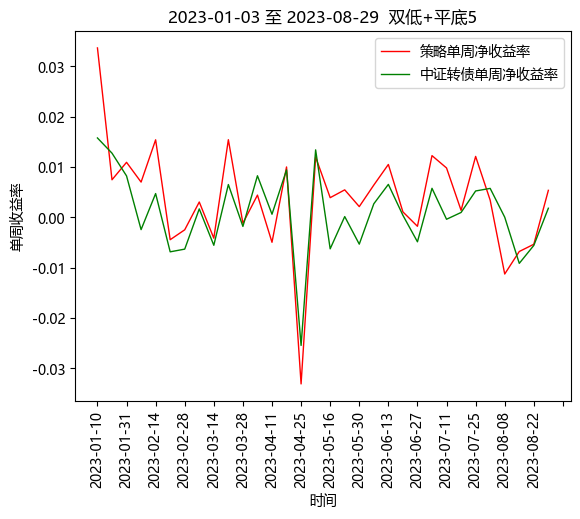

周期： 2023-01-03 至 2023-08-29
策略累计收益率：12.31%
中证转债累计收益率：3.07%
胜率1（收益率大于0的比例）：68.75%
胜率2（收益率高于中证转债指数的比例）：78.12%
夏普比率：2.13
最大回撤：3.31%
年化波动率：7.61%
收益率最好的一周： 2023-01-03 至 2023-01-10
最高单周收益率：3.37%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-3.31%
程序运行时间：4.42秒


In [15]:
"""
# 回测所有的策略
names_and_which_day = [('低价小市值5（全量数据DTBS，用于回测）.xlsx', 'mon'), 
                       ('高ytm（全量数据DTBS，用于回测）.xlsx', 'wed'), 
                       ('区间双低3（全量数据DTBS，用于回测）.xlsx', 'thu'), 
                       ('双低5（全量数据DTBS，用于回测）.xlsx', 'thu'), 
                       ('小市值3双低5（全量数据DTBS，用于回测）.xlsx', 'wed'),
                       ('热门可转债+双低（全量数据DTBS，用于回测）.xlsx', 'mon'),
                       ('低价5（全量数据DTBS，用于回测）.xlsx', 'mon'),
                       ('热门可转债+ytm（全量数据DTBS，用于回测）.xlsx','mon'),
                       ('热门可转债+低价程度（全量数据DTBS，用于回测）.xlsx', 'mon')]
# 跑多个回测周期
test_day_list = [('2021-07-01','2021-12-31'),('2022-01-01','2022-06-30'),('2022-07-01','2022-12-31'), ('2023-01-01','2023-06-30')]
"""
start_time = time.time()

# 回测单个策略（这样速度更快）
names_and_which_day = [('双低+平底5（全量数据DTBS，用于回测）.xlsx','tue')]
test_day_list = [('2023-01-01','2023-08-29')]


for start_day,end_day in test_day_list: 
    for name,which_day in names_and_which_day: 
        """两层循环是为了实现一次性回测多个策略与多个周期"""
        
        # 获得标准化持仓字典
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)
        
        # -------------------------------------------------------------------------------------------------------------------------------------------
        # 直接调用已经定义好的3个函数，传入理论的持仓字典my_position（Key是日期，Value是转债代码的列表）、trade_dates_list（交易日期的列表）
        # -------------------------------------------------------------------------------------------------------------------------------------------

        # 获得收益率曲线列表
        profit = get_period_profit(trade_dates_list, my_position, A_DF)

        # 调用画图函数，更改tick_spacing的值可以调整打印密度
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = display(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 2)
        
        # 计算各类指标
        calculate_indicators(trade_dates_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return)

end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")

<Figure size 48000x18000 with 0 Axes>

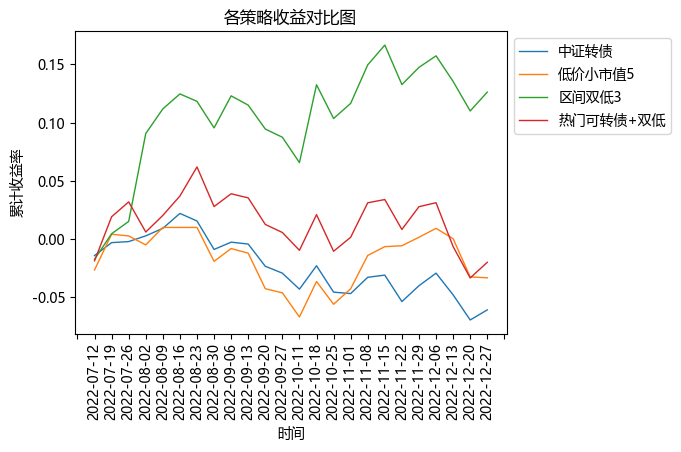

<Figure size 48000x18000 with 0 Axes>

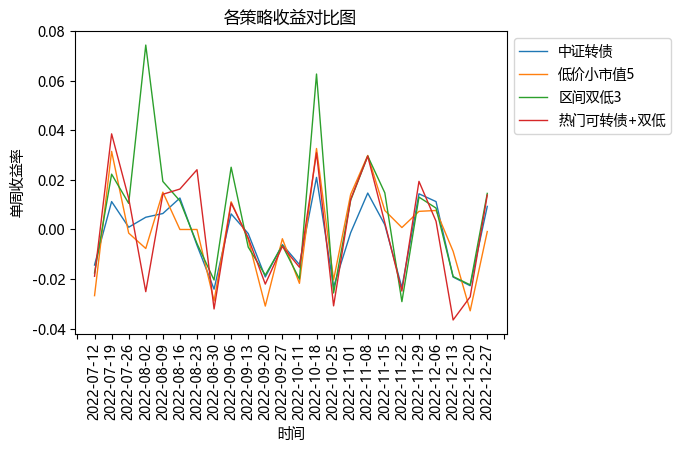

<Figure size 48000x18000 with 0 Axes>

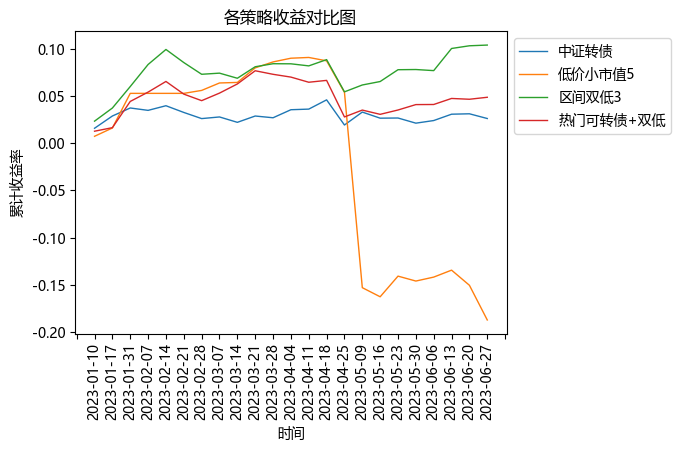

<Figure size 48000x18000 with 0 Axes>

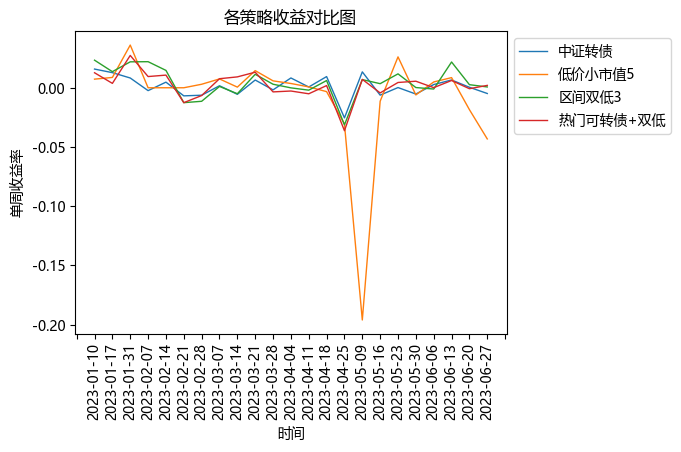

程序运行时间：20.29秒


In [16]:
# 跑1个回测周期,获得多个策略的单周收益率、累计收益率对比图
# 根据需要更改test_day_list回测周期，names策略
start_time = time.time()

test_day_list = [('2022-07-01','2022-12-31'), ('2023-01-01','2023-06-30')]

"""
需要哪些策略的收益对比图，就放进哪些，这样跑的速度快并且结果清晰
names = ['低价小市值5（全量数据DTBS，用于回测）.xlsx', 
         '高ytm（全量数据DTBS，用于回测）.xlsx', 
         '区间双低3（全量数据DTBS，用于回测）.xlsx', 
         '双低5（全量数据DTBS，用于回测）.xlsx', 
         '小市值3双低5（全量数据DTBS，用于回测）.xlsx',
         '热门可转债+双低（全量数据DTBS，用于回测）.xlsx']
"""

names = ['低价小市值5（全量数据DTBS，用于回测）.xlsx',
         '区间双低3（全量数据DTBS，用于回测）.xlsx',
         '热门可转债+双低（全量数据DTBS，用于回测）.xlsx']


set_which_day = 'mon'
          
for start_day,end_day in test_day_list:    
    profit_dict = {}   
    for name in names: 
        """
        my_position_df = pd.read_excel('pre_data_for_backtest\\'+ name)
        my_position_df = my_position_df.loc[(my_position_df['日期'] <= end_day) & (my_position_df['日期'] >= start_day)]

        # my_position = {}
        my_position_dates_list = sorted(set(list(my_position_df['日期'])))

        # trade_dates_list 设置调仓日期固定为每周几
        trade_dates_list = list(D_DF.loc[(D_DF['date'] >= start_day)&(D_DF['date'] <= end_day)&(D_DF['which_day'] == set_which_day), 'date'])

        my_position = {date : list(my_position_df.loc[my_position_df['日期'] == date,'可转债代码']) for date in  trade_dates_list}
        """        
        # 获得标准化持仓字典        
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)

        # 获得收益率曲线列表    
        profit = get_period_profit(trade_dates_list, my_position, A_DF)

        # 获取各类收益率
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = get_all_profit(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 1)
        
        strategy_name = str(name[ : name.index('（')])
        profit_dict[strategy_name] = {'weekly_return' : weekly_return, 
                                      'cumulative_return' : cumulative_return}
        
    display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = '各策略收益对比图', tick_spacing = 1)    

end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")

In [26]:
# ----------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- 分页，便于阅读 ---------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [17]:
# ----------------------------------------------------------------------------------------------------------------------
# --------------------------------------暂时用不着，以后也许有用，先留个备份，千万别删了 -------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# 这是真正意义上的回测(这是原始版本未改动)，考虑了初始仓位和剩余的现金，考虑了止损与止盈，可以实现等权重换仓与等手数换仓

# 目前这里有点问题，可转债的最小交易单位是1手（10张），即只能买入10的整数倍张可转债，之前没有考虑过这个问题，只是设定买入整数张可转债

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
import bisect

# 设置初始资金1000万元
initial_money = 10000000

def get_current_total_money(current_date, current_money, current_position_details, A_DF):
    
    """
    这个函数用于获取当前时刻账户内现金+转债价值之和,返回账户总市值
    current_date：现在的日期，
    current_money：代表账户内的现金数目,
    current_position_details：传入持仓明细字典（Key是转债代码，Value是持有这只转债的数量，请传入合法转债代码与数量）
    A_DF：全量数据库中的A区，存放3点收盘价
    """
    
    if current_position_details == {}:
        current_total_money = current_money
    else:
        # 获取当日转债价格字典
        current_day_A_DF = A_DF.loc[A_DF['date'] == current_date,['bond_code','dp']].copy()
        current_day_price_Dict = current_day_A_DF.set_index('bond_code')['dp'].to_dict()        
        current_total_money = current_money   
        
        for hold_bond_code,hold_num in current_position_details.items():            
            # price = float(A_DF.loc[(A_DF['bond_code'] == hold_bond_code) & (A_DF['date'] == current_date),'dp'])
            price = current_day_price_Dict[hold_bond_code]
            bond_money = price * hold_num
            current_total_money = current_total_money + bond_money    
            
    return current_total_money

# 用于测试get_current_total_money的功能是否有效
print(get_current_total_money('2023-07-12',900000,{'110080.SH':1000,'123098.SZ':1000},A_DF))


def reposition(trade_dates_list, last_date, current_date, current_money, current_position_details, A_DF, my_position, current_flag):
    
    """
    这个函数用于换仓，返回当前账户总市值、换仓后账户内现金、换仓后的持仓明细字典（Key是转债代码，Value是持有这只转债的数量）
    传入参数：
    current_date：现在的日期，
    current_money：当前账户内的现金数目,
    current_position_details：当前持仓明细字典（Key是转债代码，Value是持有这只转债的数量，请传入合法转债代码与数量）
    A_DF：全量数据库中的A区，存放3点收盘价
    my_position：若每日换仓，则理论上的每日持仓的转债代码的字典（Key是日期，Value是转债代码的列表）
    flag：代表换仓模式，0代表等权重调仓，1代表等手数调仓
    """
    # 设置单日涨跌幅限制、总涨跌幅限制
    # 不设当日最大涨幅限制
    daily_price_up_limit = 100
    daily_price_down_limit = -0.02
    total_price_up_limit = 0.2
    total_price_down_limit = -0.05
    
    
    # 获取当前时刻账户内现金+转债价值之和
    current_total_money = get_current_total_money(current_date, current_money, current_position_details, A_DF)
    
    # 获取当日转债价格字典
    current_day_A_DF = A_DF.loc[A_DF['date'] == current_date,['bond_code','dp']].copy()
    current_day_price_Dict = current_day_A_DF.set_index('bond_code')['dp'].to_dict()    
    
    if current_date in trade_dates_list:
        """当前日期是调仓日时，直接调仓"""
        print('\n',current_date,': 今日是调仓日')
        print('换仓前, 账户内剩余现金:',current_money,', 持仓明细字典:', current_position_details)
        # 应该换入的转债代码列表
        trade_codes_list = my_position[current_date]
        
        if len(trade_codes_list) == 0:
            print('今日无适合买入的转债，空仓。')
            return current_total_money, current_total_money, {}
        else:
            
            if current_flag == 0:
                print('等权重调仓')
                # 等权重调仓，目前没有考虑交易成本

                # 每只转债的买入限额
                limit_money = current_total_money / len(trade_codes_list)

                # 获取换仓后的持仓明细字典，最小单位为1手，即必须买入10的整数倍
                after_position_details = {trade_code:int(limit_money / current_day_price_Dict[trade_code] / 10) * 10 for trade_code in trade_codes_list}

                # 获取换仓后的账户内现金金额
                # 直接调用get_current_total_money函数算出换仓后转债的总价值，用换仓前账户内现金+转债价值之和 - 换仓后转债的总价值即可得到换仓后账户现金
                # 钱必须是两位小数，后面的数字没有意义
                after_money = int((current_total_money - get_current_total_money(current_date, 0, after_position_details, A_DF))*100)/100

            elif current_flag == 1:
                print('等份额调仓')
                # 等份额调仓，即每份转债买的数量相同
                price_list = list(current_day_A_DF.loc[current_day_A_DF.bond_code.isin(trade_codes_list),'dp'])
                price_sum = sum(price_list)
                
                # 买入份额，最小单位为1手，即必须买入10的整数倍
                i = int(current_total_money / price_sum / 10) * 10
                
                after_position_details = {trade_code : i for trade_code in trade_codes_list}   
                after_money = int(((current_total_money - price_sum * i))*100)/100
                
            print('换仓后, 账户内剩余现金:',after_money,', 持仓明细字典:', after_position_details)
            return current_total_money, after_money, after_position_details
    else:
        """当前日期不是调仓日时，查看当前转债是否有需要止损或者止盈，若有则卖出，并重新调整仓位"""
        current_code_list = list(current_position_details.keys())
        
        # 获得上一个交易日的价格字典
        last_day_A_DF = A_DF.loc[A_DF['date'] == last_date,['bond_code','dp']].copy()
        last_day_price_Dict = last_day_A_DF.set_index('bond_code')['dp'].to_dict()
        
        # 找到上一次换仓日，获得上一个换仓日的价格字典
        last_trade_date = trade_dates_list[bisect.bisect_right(trade_dates_list, current_date)-1]
        last_trade_day_A_DF = A_DF.loc[A_DF['date'] == last_trade_date,['bond_code','dp']].copy()
        last_trade_day_price_Dict = last_trade_day_A_DF.set_index('bond_code')['dp'].to_dict()
        
        
        after_code_list = []
        
        print('\n', current_date,': 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。')
        print('换仓前, 账户内剩余现金:',current_money,', 持仓明细字典:', current_position_details)
        
        if len(current_code_list) == 0:
            print('空仓，无需监控。')
            return current_total_money, current_total_money, {}
        else:
            for current_code in current_code_list:
                if current_day_price_Dict[current_code] / last_day_price_Dict[current_code] - 1 > daily_price_up_limit:
                    print(current_code,'：突破当日最大涨幅限制，需要止盈。')
                elif current_day_price_Dict[current_code] / last_day_price_Dict[current_code] - 1 < daily_price_down_limit:
                    print(current_code,'：突破当日最大跌幅限制，需要止损。')
                elif current_day_price_Dict[current_code] / last_trade_day_price_Dict[current_code] -1 > total_price_up_limit:
                    print(current_code,'：突破最大涨幅限制，需要止盈。')
                elif current_day_price_Dict[current_code] / last_trade_day_price_Dict[current_code] -1 < total_price_down_limit:
                    print(current_code,'：突破最大跌幅限制，需要止损。')
                else:
                    after_code_list.append(current_code)
                    
            if len(after_code_list) < len(current_code_list):
                print('有转债止损/止盈，当日需要重新调仓！')
                
                if len(after_code_list) == 0:
                    print('今日调仓后所有转债均已卖出，空仓。')
                    return current_total_money, current_total_money, {}
                
                else:
                    if current_flag == 0:
                        print('等权重调仓')
                        # 等权重调仓，目前没有考虑交易成本

                        # 每只转债的买入限额
                        limit_money = current_total_money / len(after_code_list)

                        # 获取换仓后的持仓明细字典，最小单位为1手，即必须买入10的整数倍
                        after_position_details = {trade_code:int(limit_money / current_day_price_Dict[after_code] / 10) * 10 for after_code in after_code_list}

                        # 获取换仓后的账户内现金金额
                        # 直接调用get_current_total_money函数算出换仓后转债的总价值，用换仓前账户内现金+转债价值之和 - 换仓后转债的总价值即可得到换仓后账户现金
                        # 钱必须是两位小数，后面的数字没有意义
                        after_money = int((current_total_money - get_current_total_money(current_date, 0, after_position_details, A_DF))*100)/100

                    elif current_flag == 1:
                        # 等份额调仓，即每份转债买的数量相同
                        print('等份额调仓')
                        price_list = list(current_day_A_DF.loc[current_day_A_DF.bond_code.isin(after_code_list),'dp'])
                        price_sum = sum(price_list)
                        
                        # 买入份额，最小单位为1手，即必须买入10的整数倍
                        i = int(current_total_money / price_sum / 10) * 10
                        after_position_details = {after_code : i for after_code in after_code_list}   
                        after_money = int(((current_total_money - price_sum * i))*100)/100

                    print('换仓后, 账户内剩余现金:',after_money,', 持仓明细字典:', after_position_details)
                    return current_total_money, after_money, after_position_details
                
            else:
                print('没有转债需要止损/止盈，当日无需重新调仓！')
                return current_total_money, current_money, current_position_details
                
# 用于测试reposition的功能是否有效
# reposition('2023-07-12', 900000, {'110080.SH':1000,'123098.SZ':1000}, A_DF, my_position, 0)

def get_weekly_return(trade_dates_list,D_DF,A_DF,initial_money,my_position,my_current_flag):
    # 返回单周收益率列表  
    start_day = trade_dates_list[0]
    end_day = trade_dates_list[-1]
    
    test_dates_list = sorted(list(D_DF.loc[(D_DF['date'] >= start_day) & (D_DF['date'] <= end_day),'date']))
    
    total_money_list = []
    
    # 第一次换仓
    current_total_money, after_money, after_position_details = reposition(trade_dates_list, '', test_dates_list[0], initial_money, {}, A_DF, my_position, current_flag=my_current_flag)
    total_money_list.append(current_total_money)
    
    # 后续换仓
    for test_day_index in range(1,len(test_dates_list)):
        current_date = test_dates_list[test_day_index]
        last_date = test_dates_list[test_day_index-1]
        current_total_money, after_money, after_position_details = reposition(trade_dates_list, last_date, current_date, after_money, after_position_details, A_DF, my_position, current_flag=my_current_flag)
        if current_date in trade_dates_list:
            total_money_list.append(current_total_money)
    
    profit = [total_money_list[index] / total_money_list[index-1] - 1 for index in range(1, len(total_money_list))]
    # print(total_money_list,profit)
    
    return profit


1196433.0



 2021-04-26 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}

 2021-04-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-05-06 : 今日是非


 2021-06-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3567.25 , 持仓明细字典: {'123011.SZ': 20280, '113601.SH': 20280, '113566.SH': 20280, '113624.SH': 20280, '123080.SZ': 20280}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-06-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3567.25 , 持仓明细字典: {'123011.SZ': 20280, '113601.SH': 20280, '113566.SH': 20280, '113624.SH': 20280, '123080.SZ': 20280}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-06-28 : 今日是调仓日
换仓前, 账户内剩余现金: 3567.25 , 持仓明细字典: {'123011.SZ': 20280, '113601.SH': 20280, '113566.SH': 20280, '113624.SH': 20280, '123080.SZ': 20280}
等份额调仓
换仓后, 账户内剩余现金: 1559.26 , 持仓明细字典: {'113573.SH': 20900, '123023.SZ': 20900, '128118.SZ': 20900, '128069.SZ': 20900, '123080.SZ': 20900}

 2021-06-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1559.26 , 持仓明细字典: {'113573.SH': 20900, '123023.SZ': 20900, '128118.SZ': 20900, '128069.SZ': 20900, '123080.SZ': 20900}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-06-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1559.26 , 持仓明细字典: {'113573.SH': 20900, '123023.SZ': 20900, '128


 2021-08-18 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4633.1 , 持仓明细字典: {'123028.SZ': 21740, '128117.SZ': 21740, '113600.SH': 21740, '113624.SH': 21740, '128022.SZ': 21740}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-19 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4633.1 , 持仓明细字典: {'123028.SZ': 21740, '128117.SZ': 21740, '113600.SH': 21740, '113624.SH': 21740, '128022.SZ': 21740}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-20 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4633.1 , 持仓明细字典: {'123028.SZ': 21740, '128117.SZ': 21740, '113600.SH': 21740, '113624.SH': 21740, '128022.SZ': 21740}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-23 : 今日是调仓日
换仓前, 账户内剩余现金: 4633.1 , 持仓明细字典: {'123028.SZ': 21740, '128117.SZ': 21740, '113600.SH': 21740, '113624.SH': 21740, '128022.SZ': 21740}
等份额调仓
换仓后, 账户内剩余现金: 4885.51 , 持仓明细字典: {'123028.SZ': 21450, '113591.SH': 21450, '128074.SZ': 21450, '113624.SH': 21450, '113546.SH': 21450}

 2021-08-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4885.51 , 持仓明细字典: {'123028.SZ': 21450, '113591.SH': 21450, '128074.


 2021-10-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 243.35 , 持仓明细字典: {'128066.SZ': 23700, '123106.SZ': 23700, '128070.SZ': 23700, '123082.SZ': 23700, '113546.SH': 23700}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 243.35 , 持仓明细字典: {'128066.SZ': 23700, '123106.SZ': 23700, '128070.SZ': 23700, '123082.SZ': 23700, '113546.SH': 23700}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-25 : 今日是调仓日
换仓前, 账户内剩余现金: 243.35 , 持仓明细字典: {'128066.SZ': 23700, '123106.SZ': 23700, '128070.SZ': 23700, '123082.SZ': 23700, '113546.SH': 23700}
等份额调仓
换仓后, 账户内剩余现金: 879.04 , 持仓明细字典: {'123056.SZ': 24340, '123126.SZ': 24340, '123093.SZ': 24340, '128074.SZ': 24340, '113628.SH': 24340}

 2021-10-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 879.04 , 持仓明细字典: {'123056.SZ': 24340, '123126.SZ': 24340, '123093.SZ': 24340, '128074.SZ': 24340, '113628.SH': 24340}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 879.04 , 持仓明细字典: {'123056.SZ': 24340, '123126.SZ': 24340, '123093.SZ


 2021-12-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 827.17 , 持仓明细字典: {'113589.SH': 26210, '113519.SH': 26210, '113601.SH': 26210, '128069.SZ': 26210, '113597.SH': 26210}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-16 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 827.17 , 持仓明细字典: {'113589.SH': 26210, '113519.SH': 26210, '113601.SH': 26210, '128069.SZ': 26210, '113597.SH': 26210}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 827.17 , 持仓明细字典: {'113589.SH': 26210, '113519.SH': 26210, '113601.SH': 26210, '128069.SZ': 26210, '113597.SH': 26210}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-20 : 今日是调仓日
换仓前, 账户内剩余现金: 827.17 , 持仓明细字典: {'113589.SH': 26210, '113519.SH': 26210, '113601.SH': 26210, '128069.SZ': 26210, '113597.SH': 26210}
等份额调仓
换仓后, 账户内剩余现金: 5514.07 , 持仓明细字典: {'113519.SH': 26200, '123056.SZ': 26200, '128117.SZ': 26200, '113573.SH': 26200, '128118.SZ': 26200}

 2021-12-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 5514.07 , 持仓明细字典: {'113519.SH': 26200, '123056.SZ': 26200, '128117.


 2022-02-18 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 21.43 , 持仓明细字典: {'128138.SZ': 44560, '128118.SZ': 44560, '113584.SH': 44560}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-21 : 今日是调仓日
换仓前, 账户内剩余现金: 21.43 , 持仓明细字典: {'128138.SZ': 44560, '128118.SZ': 44560, '113584.SH': 44560}
等份额调仓
换仓后, 账户内剩余现金: 1451.82 , 持仓明细字典: {'113569.SH': 26100, '123093.SZ': 26100, '113573.SH': 26100, '123065.SZ': 26100, '113566.SH': 26100}

 2022-02-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1451.82 , 持仓明细字典: {'113569.SH': 26100, '123093.SZ': 26100, '113573.SH': 26100, '123065.SZ': 26100, '113566.SH': 26100}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1451.82 , 持仓明细字典: {'113569.SH': 26100, '123093.SZ': 26100, '113573.SH': 26100, '123065.SZ': 26100, '113566.SH': 26100}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1451.82 , 持仓明细字典: {'113569.SH': 26100, '123093.SZ': 26100, '113573.SH': 26100, '123065.SZ': 26100, '113566.SH': 26100}
没有转债需要止损/止盈，当日无需重新调仓！

 2022


 2022-04-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1255.54 , 持仓明细字典: {'113573.SH': 26730, '128074.SZ': 26730, '123093.SZ': 26730, '113628.SH': 26730, '113594.SH': 26730}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1255.54 , 持仓明细字典: {'113573.SH': 26730, '128074.SZ': 26730, '123093.SZ': 26730, '113628.SH': 26730, '113594.SH': 26730}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-18 : 今日是调仓日
换仓前, 账户内剩余现金: 1255.54 , 持仓明细字典: {'113573.SH': 26730, '128074.SZ': 26730, '123093.SZ': 26730, '113628.SH': 26730, '113594.SH': 26730}
等份额调仓
换仓后, 账户内剩余现金: 1488.77 , 持仓明细字典: {'113569.SH': 27590, '128074.SZ': 27590, '113628.SH': 27590, '113584.SH': 27590, '123088.SZ': 27590}
单周收益率： [0.03189324900000012, 0.009115919703046593, 0.01907034265983154, 0.004595730970094802, -0.0042394991689233, -0.009805870946393735, 0.032323172303727166, -0.008665628918828272, 0.031900563064819476, 0.009978023024142635, -0.009503253710445247, 0.013735165874046107, 0.008855627334176663, 0.009441406075744618

<Figure size 36000x18000 with 0 Axes>

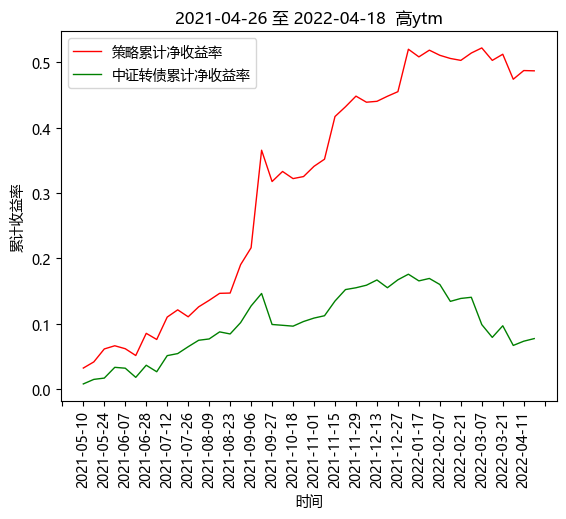

<Figure size 36000x18000 with 0 Axes>

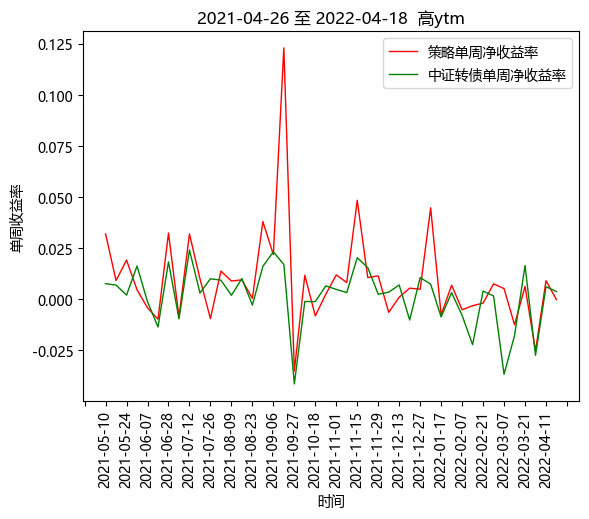

周期： 2021-04-26 至 2022-04-18
策略累计收益率：48.72%
中证转债累计收益率：7.7%
胜率1（收益率大于0的比例）：68.18%
胜率2（收益率高于中证转债指数的比例）：68.18%
夏普比率：2.67
最大回撤：3.51%
年化波动率：16.3%
收益率最好的一周： 2021-09-06 至 2021-09-13
最高单周收益率：12.28%
收益率最差的一周： 2021-09-13 至 2021-09-27
最低单周收益率：-3.51%
程序运行时间：22.41秒


In [18]:
# 回测单个策略（这样速度更快），考虑了初始仓位和剩余的现金，考虑了止损与止盈，可以实现等权重换仓与等手数换仓
names_and_which_day = [('高ytm（全量数据DTBS，用于回测）.xlsx', 'mon')]
test_day_list = [('2021-04-20','2022-04-19')]

start_time = time.time()

for start_day,end_day in test_day_list: 
    for name,which_day in names_and_which_day: 
        """两层循环是为了实现一次性回测多个策略与多个周期"""
        
        # 获得标准化持仓字典        
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)
        
        # -------------------------------------------------------------------------------------------------------------------------------------------
        # 直接调用已经定义好的3个函数，传入理论的持仓字典my_position（Key是日期，Value是转债代码的列表）、trade_dates_list（交易日期的列表）
        # -------------------------------------------------------------------------------------------------------------------------------------------

        # 获得收益率曲线列表    
        profit = get_weekly_return(trade_dates_list,D_DF,A_DF,10000000,my_position,my_current_flag=1)

        # 调用画图函数，更改tick_spacing的值可以调整打印密度
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = display(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 2)
        
        # 计算各类指标
        calculate_indicators(trade_dates_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return)

end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")


 2022-07-04 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 2157.75 , 持仓明细字典: {'110070.SH': 39640, '128143.SZ': 39640}

 2022-07-05 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2157.75 , 持仓明细字典: {'110070.SH': 39640, '128143.SZ': 39640}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-06 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2157.75 , 持仓明细字典: {'110070.SH': 39640, '128143.SZ': 39640}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-07 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2157.75 , 持仓明细字典: {'110070.SH': 39640, '128143.SZ': 39640}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-08 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2157.75 , 持仓明细字典: {'110070.SH': 39640, '128143.SZ': 39640}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-11 : 今日是调仓日
换仓前, 账户内剩余现金: 2157.75 , 持仓明细字典: {'110070.SH': 39640, '128143.SZ': 39640}
等份额调仓
换仓后, 账户内剩余现金: 3030.27 , 持仓明细字典: {'113030.SH': 16010, '123080.SZ': 16010, '123002.SZ': 16010, '113565.SH': 16010, '113577.SH': 16010}

 2022-07-12 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3030.27 , 持仓明细字典: {'113030.SH'


 2022-09-07 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4494.6 , 持仓明细字典: {'113030.SH': 17490, '110070.SH': 17490, '128076.SZ': 17490, '128071.SZ': 17490, '113565.SH': 17490}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-08 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4494.6 , 持仓明细字典: {'113030.SH': 17490, '110070.SH': 17490, '128076.SZ': 17490, '128071.SZ': 17490, '113565.SH': 17490}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-09 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4494.6 , 持仓明细字典: {'113030.SH': 17490, '110070.SH': 17490, '128076.SZ': 17490, '128071.SZ': 17490, '113565.SH': 17490}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-13 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4494.6 , 持仓明细字典: {'113030.SH': 17490, '110070.SH': 17490, '128076.SZ': 17490, '128071.SZ': 17490, '113565.SH': 17490}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4494.6 , 持仓明细字典: {'113030.SH': 17490, '110070.SH': 17490, '128076.SZ': 17490, '128071.SZ': 17490, '113565.SH': 17490}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-15 : 今日是非调仓日，监控


 2022-11-09 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 984.22 , 持仓明细字典: {'111003.SH': 86580}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-10 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 984.22 , 持仓明细字典: {'111003.SH': 86580}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-11 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 984.22 , 持仓明细字典: {'111003.SH': 86580}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-14 : 今日是调仓日
换仓前, 账户内剩余现金: 984.22 , 持仓明细字典: {'111003.SH': 86580}
等份额调仓
换仓后, 账户内剩余现金: 4248.51 , 持仓明细字典: {'123139.SZ': 17550, '113561.SH': 17550, '113570.SH': 17550, '128143.SZ': 17550, '111003.SH': 17550}

 2022-11-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4248.51 , 持仓明细字典: {'123139.SZ': 17550, '113561.SH': 17550, '113570.SH': 17550, '128143.SZ': 17550, '111003.SH': 17550}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-16 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4248.51 , 持仓明细字典: {'123139.SZ': 17550, '113561.SH': 17550, '113570.SH': 17550, '128143.SZ': 17550, '111003.SH': 17550}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩


 2022-07-12 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1436.08 , 持仓明细字典: {'128066.SZ': 13570, '128085.SZ': 13570, '123129.SZ': 13570, '123063.SZ': 13570, '123080.SZ': 13570, '123100.SZ': 13570}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-13 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1436.08 , 持仓明细字典: {'128066.SZ': 13570, '128085.SZ': 13570, '123129.SZ': 13570, '123063.SZ': 13570, '123080.SZ': 13570, '123100.SZ': 13570}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1436.08 , 持仓明细字典: {'128066.SZ': 13570, '128085.SZ': 13570, '123129.SZ': 13570, '123063.SZ': 13570, '123080.SZ': 13570, '123100.SZ': 13570}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1436.08 , 持仓明细字典: {'128066.SZ': 13570, '128085.SZ': 13570, '123129.SZ': 13570, '123063.SZ': 13570, '123080.SZ': 13570, '123100.SZ': 13570}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-18 : 今日是调仓日
换仓前, 账户内剩余现金: 1436.08 , 持仓明细字典: {'128066.SZ': 13570, '128085.SZ': 13570, '123129.SZ': 13570, '123063.SZ': 13570, '


 2022-08-31 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2622.58 , 持仓明细字典: {'123129.SZ': 14680, '127054.SZ': 14680, '113588.SH': 14680, '113649.SH': 14680, '123087.SZ': 14680, '123050.SZ': 14680}
123087.SZ ：突破当日最大跌幅限制，需要止损。
123050.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 288.11 , 持仓明细字典: {'123129.SZ': 22260, '127054.SZ': 22260, '113588.SH': 22260, '113649.SH': 22260}

 2022-09-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 288.11 , 持仓明细字典: {'123129.SZ': 22260, '127054.SZ': 22260, '113588.SH': 22260, '113649.SH': 22260}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 288.11 , 持仓明细字典: {'123129.SZ': 22260, '127054.SZ': 22260, '113588.SH': 22260, '113649.SH': 22260}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-05 : 今日是调仓日
换仓前, 账户内剩余现金: 288.11 , 持仓明细字典: {'123129.SZ': 22260, '127054.SZ': 22260, '113588.SH': 22260, '113649.SH': 22260}
等份额调仓
换仓后, 账户内剩余现金: 1777.94 , 持仓明细字典: {'128071.SZ': 14680, '128097.SZ': 14680, '113593.SH': 14680, '123063.SZ': 14680, '113600.SH


 2022-10-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3577.82 , 持仓明细字典: {'128066.SZ': 18000, '128085.SZ': 18000, '113532.SH': 18000, '123130.SZ': 18000, '123156.SZ': 18000}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-31 : 今日是调仓日
换仓前, 账户内剩余现金: 3577.82 , 持仓明细字典: {'128066.SZ': 18000, '128085.SZ': 18000, '113532.SH': 18000, '123130.SZ': 18000, '123156.SZ': 18000}
等份额调仓
换仓后, 账户内剩余现金: 6675.66 , 持仓明细字典: {'128066.SZ': 14510, '128075.SZ': 14510, '123063.SZ': 14510, '113649.SH': 14510, '123147.SZ': 14510, '123156.SZ': 14510}

 2022-11-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 6675.66 , 持仓明细字典: {'128066.SZ': 14510, '128075.SZ': 14510, '123063.SZ': 14510, '113649.SH': 14510, '123147.SZ': 14510, '123156.SZ': 14510}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 6675.66 , 持仓明细字典: {'128066.SZ': 14510, '128075.SZ': 14510, '123063.SZ': 14510, '113649.SH': 14510, '123147.SZ': 14510, '123156.SZ': 14510}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-03 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 667


 2022-12-19 : 今日是调仓日
换仓前, 账户内剩余现金: 2269.0 , 持仓明细字典: {'128085.SZ': 15260, '118016.SH': 15260, '123082.SZ': 15260, '113591.SH': 15260, '123141.SZ': 15260, '123144.SZ': 15260}
等份额调仓
换仓后, 账户内剩余现金: 4048.45 , 持仓明细字典: {'123063.SZ': 14600, '113591.SH': 14600, '123144.SZ': 14600, '111004.SH': 14600, '123089.SZ': 14600, '123162.SZ': 14600}

 2022-12-20 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4048.45 , 持仓明细字典: {'123063.SZ': 14600, '113591.SH': 14600, '123144.SZ': 14600, '111004.SH': 14600, '123089.SZ': 14600, '123162.SZ': 14600}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4048.45 , 持仓明细字典: {'123063.SZ': 14600, '113591.SH': 14600, '123144.SZ': 14600, '111004.SH': 14600, '123089.SZ': 14600, '123162.SZ': 14600}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4048.45 , 持仓明细字典: {'123063.SZ': 14600, '113591.SH': 14600, '123144.SZ': 14600, '111004.SH': 14600, '123089.SZ': 14600, '123162.SZ': 14600}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-23 : 今日是非


 2022-08-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 204.1 , 持仓明细字典: {'113546.SH': 20370, '127060.SZ': 20370, '128037.SZ': 20370, '128075.SZ': 20370}
113546.SH ：突破当日最大跌幅限制，需要止损。
128075.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 292.16 , 持仓明细字典: {'127060.SZ': 41150, '128037.SZ': 41150}

 2022-08-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 292.16 , 持仓明细字典: {'127060.SZ': 41150, '128037.SZ': 41150}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 292.16 , 持仓明细字典: {'127060.SZ': 41150, '128037.SZ': 41150}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-29 : 今日是调仓日
换仓前, 账户内剩余现金: 292.16 , 持仓明细字典: {'127060.SZ': 41150, '128037.SZ': 41150}
等份额调仓
换仓后, 账户内剩余现金: 8931.8 , 持仓明细字典: {'113519.SH': 8890, '113600.SH': 8890, '123002.SZ': 8890, '123063.SZ': 8890, '123088.SZ': 8890, '123147.SZ': 8890, '128033.SZ': 8890, '128037.SZ': 8890, '128121.SZ': 8890}

 2022-08-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 8931.8 , 持仓明细字典: {'113519.SH': 8890, '113600.SH': 8890, '123002.SZ'


 2022-10-13 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2036.11 , 持仓明细字典: {'110074.SH': 7310, '113030.SH': 7310, '113039.SH': 7310, '113598.SH': 7310, '113649.SH': 7310, '127028.SZ': 7310, '128037.SZ': 7310, '128042.SZ': 7310, '128097.SZ': 7310, '128121.SZ': 7310}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2036.11 , 持仓明细字典: {'110074.SH': 7310, '113030.SH': 7310, '113039.SH': 7310, '113598.SH': 7310, '113649.SH': 7310, '127028.SZ': 7310, '128037.SZ': 7310, '128042.SZ': 7310, '128097.SZ': 7310, '128121.SZ': 7310}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-17 : 今日是调仓日
换仓前, 账户内剩余现金: 2036.11 , 持仓明细字典: {'110074.SH': 7310, '113030.SH': 7310, '113039.SH': 7310, '113598.SH': 7310, '113649.SH': 7310, '127028.SZ': 7310, '128037.SZ': 7310, '128042.SZ': 7310, '128097.SZ': 7310, '128121.SZ': 7310}
等份额调仓
换仓后, 账户内剩余现金: 6198.85 , 持仓明细字典: {'113588.SH': 12810, '123132.SZ': 12810, '127007.SZ': 12810, '127028.SZ': 12810, '127060.SZ': 12810, '128097.SZ': 12810}

 2022-10-18 : 今日是非调仓日，监


 2022-11-21 : 今日是调仓日
换仓前, 账户内剩余现金: 3243.48 , 持仓明细字典: {'111004.SH': 26480, '123157.SZ': 26480, '128066.SZ': 26480}
等份额调仓
换仓后, 账户内剩余现金: 2937.85 , 持仓明细字典: {'118021.SH': 15500, '123156.SZ': 15500, '123157.SZ': 15500, '127028.SZ': 15500, '127060.SZ': 15500}

 2022-11-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2937.85 , 持仓明细字典: {'118021.SH': 15500, '123156.SZ': 15500, '123157.SZ': 15500, '127028.SZ': 15500, '127060.SZ': 15500}
118021.SH ：突破当日最大跌幅限制，需要止损。
127028.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 2729.53 , 持仓明细字典: {'123156.SZ': 25870, '123157.SZ': 25870, '127060.SZ': 25870}

 2022-11-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2729.53 , 持仓明细字典: {'123156.SZ': 25870, '123157.SZ': 25870, '127060.SZ': 25870}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2729.53 , 持仓明细字典: {'123156.SZ': 25870, '123157.SZ': 25870, '127060.SZ': 25870}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2729.53 , 持仓明细字典: {'123156.SZ':

<Figure size 48000x18000 with 0 Axes>

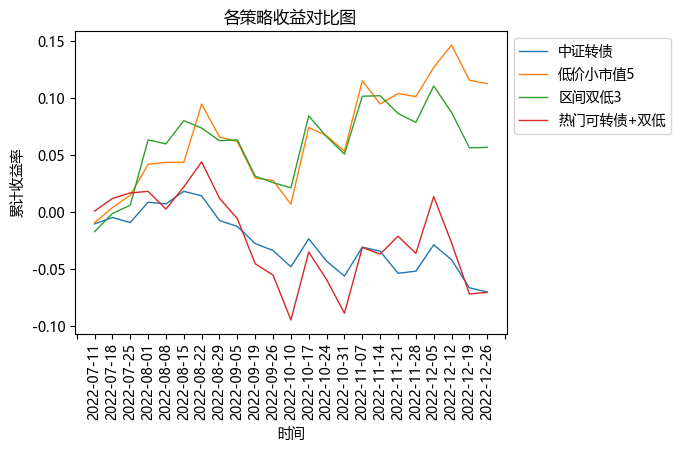

<Figure size 48000x18000 with 0 Axes>

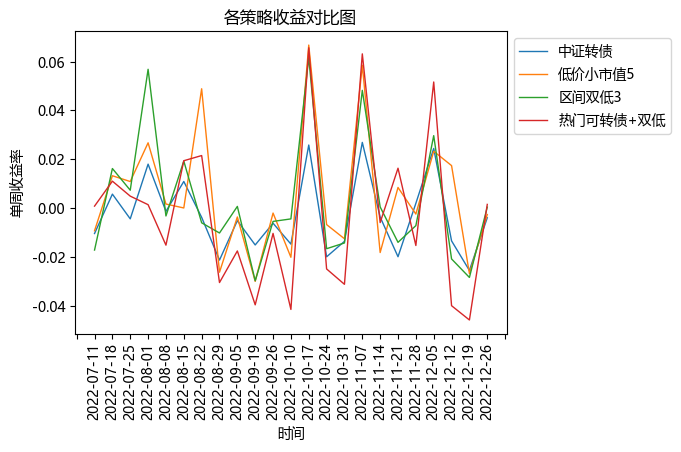


 2023-01-09 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 620.43 , 持仓明细字典: {'113565.SH': 16690, '110070.SH': 16690, '113030.SH': 16690, '113577.SH': 16690, '128021.SZ': 16690}

 2023-01-10 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 620.43 , 持仓明细字典: {'113565.SH': 16690, '110070.SH': 16690, '113030.SH': 16690, '113577.SH': 16690, '128021.SZ': 16690}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-01-11 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 620.43 , 持仓明细字典: {'113565.SH': 16690, '110070.SH': 16690, '113030.SH': 16690, '113577.SH': 16690, '128021.SZ': 16690}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-01-12 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 620.43 , 持仓明细字典: {'113565.SH': 16690, '110070.SH': 16690, '113030.SH': 16690, '113577.SH': 16690, '128021.SZ': 16690}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-01-13 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 620.43 , 持仓明细字典: {'113565.SH': 16690, '110070.SH': 16690, '113030.SH': 16690, '113577.SH': 16690, '128021.SZ': 16690}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-01-16 : 今日是调仓日
换仓


 2023-03-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2876.07 , 持仓明细字典: {'123103.SZ': 21940, '113565.SH': 21940, '113527.SH': 21940, '113566.SH': 21940}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2876.07 , 持仓明细字典: {'123103.SZ': 21940, '113565.SH': 21940, '113527.SH': 21940, '113566.SH': 21940}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2876.07 , 持仓明细字典: {'123103.SZ': 21940, '113565.SH': 21940, '113527.SH': 21940, '113566.SH': 21940}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-31 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2876.07 , 持仓明细字典: {'123103.SZ': 21940, '113565.SH': 21940, '113527.SH': 21940, '113566.SH': 21940}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-04-03 : 今日是调仓日
换仓前, 账户内剩余现金: 2876.07 , 持仓明细字典: {'123103.SZ': 21940, '113565.SH': 21940, '113527.SH': 21940, '113566.SH': 21940}
等份额调仓
换仓后, 账户内剩余现金: 4161.0 , 持仓明细字典: {'128033.SZ': 17530, '110070.SH': 17530, '128039.SZ': 17530, '123103.SZ': 17530, '113577.SH': 17530}

 2023-04-04 : 今日是非调仓日，


 2023-05-29 : 今日是调仓日
换仓前, 账户内剩余现金: 2450.89 , 持仓明细字典: {'113526.SH': 18100, '113561.SH': 18100, '128039.SZ': 18100, '128021.SZ': 18100, '113566.SH': 18100}
等份额调仓
换仓后, 账户内剩余现金: 1363.43 , 持仓明细字典: {'113566.SH': 17710, '128039.SZ': 17710, '113526.SH': 17710, '110070.SH': 17710, '128053.SZ': 17710}

 2023-05-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1363.43 , 持仓明细字典: {'113566.SH': 17710, '128039.SZ': 17710, '113526.SH': 17710, '110070.SH': 17710, '128053.SZ': 17710}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-05-31 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1363.43 , 持仓明细字典: {'113566.SH': 17710, '128039.SZ': 17710, '113526.SH': 17710, '110070.SH': 17710, '128053.SZ': 17710}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1363.43 , 持仓明细字典: {'113566.SH': 17710, '128039.SZ': 17710, '113526.SH': 17710, '110070.SH': 17710, '128053.SZ': 17710}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1363.43 , 持仓明细字典: {'113566.SH': 17710, '128039.SZ': 17710, '113


 2023-02-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1817.49 , 持仓明细字典: {'128066.SZ': 15060, '113532.SH': 15060, '113628.SH': 15060, '123063.SZ': 15060, '127055.SZ': 15060, '113665.SH': 15060}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1817.49 , 持仓明细字典: {'128066.SZ': 15060, '113532.SH': 15060, '113628.SH': 15060, '123063.SZ': 15060, '127055.SZ': 15060, '113665.SH': 15060}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-16 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1817.49 , 持仓明细字典: {'128066.SZ': 15060, '113532.SH': 15060, '113628.SH': 15060, '123063.SZ': 15060, '127055.SZ': 15060, '113665.SH': 15060}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1817.49 , 持仓明细字典: {'128066.SZ': 15060, '113532.SH': 15060, '113628.SH': 15060, '123063.SZ': 15060, '127055.SZ': 15060, '113665.SH': 15060}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-20 : 今日是调仓日
换仓前, 账户内剩余现金: 1817.49 , 持仓明细字典: {'128066.SZ': 15060, '113532.SH': 15060, '113628.SH': 15060, '123063.SZ': 15060, '


 2023-04-06 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 6373.79 , 持仓明细字典: {'118016.SH': 14750, '113628.SH': 14750, '113532.SH': 14750, '123141.SZ': 14750, '123162.SZ': 14750, '127059.SZ': 14750}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-04-07 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 6373.79 , 持仓明细字典: {'118016.SH': 14750, '113628.SH': 14750, '113532.SH': 14750, '123141.SZ': 14750, '123162.SZ': 14750, '127059.SZ': 14750}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-04-10 : 今日是调仓日
换仓前, 账户内剩余现金: 6373.79 , 持仓明细字典: {'118016.SH': 14750, '113628.SH': 14750, '113532.SH': 14750, '123141.SZ': 14750, '123162.SZ': 14750, '127059.SZ': 14750}
等份额调仓
换仓后, 账户内剩余现金: 6115.63 , 持仓明细字典: {'118016.SH': 14700, '127059.SZ': 14700, '113628.SH': 14700, '123141.SZ': 14700, '123175.SZ': 14700, '123153.SZ': 14700}

 2023-04-11 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 6115.63 , 持仓明细字典: {'118016.SH': 14700, '127059.SZ': 14700, '113628.SH': 14700, '123141.SZ': 14700, '123175.SZ': 14700, '123153.SZ': 14700}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-04-12 : 今日是


 2023-05-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 5829.26 , 持仓明细字典: {'118016.SH': 14470, '123160.SZ': 14470, '113628.SH': 14470, '123141.SZ': 14470, '123063.SZ': 14470, '113649.SH': 14470}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-05-29 : 今日是调仓日
换仓前, 账户内剩余现金: 5829.26 , 持仓明细字典: {'118016.SH': 14470, '123160.SZ': 14470, '113628.SH': 14470, '123141.SZ': 14470, '123063.SZ': 14470, '113649.SH': 14470}
等份额调仓
换仓后, 账户内剩余现金: 1516.62 , 持仓明细字典: {'118016.SH': 14590, '123160.SZ': 14590, '113651.SH': 14590, '123063.SZ': 14590, '113628.SH': 14590, '123141.SZ': 14590}

 2023-05-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1516.62 , 持仓明细字典: {'118016.SH': 14590, '123160.SZ': 14590, '113651.SH': 14590, '123063.SZ': 14590, '113628.SH': 14590, '123141.SZ': 14590}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-05-31 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1516.62 , 持仓明细字典: {'118016.SH': 14590, '123160.SZ': 14590, '113651.SH': 14590, '123063.SZ': 14590, '113628.SH': 14590, '123141.SZ': 14590}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-01 : 今日是


 2023-02-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 5602.03 , 持仓明细字典: {'127028.SZ': 16540, '127054.SZ': 16540, '127055.SZ': 16540, '128044.SZ': 16540, '128090.SZ': 16540}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 5602.03 , 持仓明细字典: {'127028.SZ': 16540, '127054.SZ': 16540, '127055.SZ': 16540, '128044.SZ': 16540, '128090.SZ': 16540}
128044.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 2401.2 , 持仓明细字典: {'127028.SZ': 20500, '127054.SZ': 20500, '127055.SZ': 20500, '128090.SZ': 20500}

 2023-02-03 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2401.2 , 持仓明细字典: {'127028.SZ': 20500, '127054.SZ': 20500, '127055.SZ': 20500, '128090.SZ': 20500}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-06 : 今日是调仓日
换仓前, 账户内剩余现金: 2401.2 , 持仓明细字典: {'127028.SZ': 20500, '127054.SZ': 20500, '127055.SZ': 20500, '128090.SZ': 20500}
等份额调仓
换仓后, 账户内剩余现金: 5023.4 , 持仓明细字典: {'123075.SZ': 16300, '127028.SZ': 16300, '127054.SZ': 16300, '128044.SZ': 16300, '128049.SZ': 16300}

 2023-02-07 : 今日是


 2023-03-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 5516.17 , 持仓明细字典: {'110070.SH': 9980, '113588.SH': 9980, '123130.SZ': 9980, '123147.SZ': 9980, '123168.SZ': 9980, '127035.SZ': 9980, '128075.SZ': 9980, '128087.SZ': 9980}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-20 : 今日是调仓日
换仓前, 账户内剩余现金: 5516.17 , 持仓明细字典: {'110070.SH': 9980, '113588.SH': 9980, '123130.SZ': 9980, '123147.SZ': 9980, '123168.SZ': 9980, '127035.SZ': 9980, '128075.SZ': 9980, '128087.SZ': 9980}
等份额调仓
换仓后, 账户内剩余现金: 6128.15 , 持仓明细字典: {'123130.SZ': 16020, '123136.SZ': 16020, '123147.SZ': 16020, '127035.SZ': 16020, '128049.SZ': 16020}

 2023-03-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 6128.15 , 持仓明细字典: {'123130.SZ': 16020, '123136.SZ': 16020, '123147.SZ': 16020, '127035.SZ': 16020, '128049.SZ': 16020}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 6128.15 , 持仓明细字典: {'123130.SZ': 16020, '123136.SZ': 16020, '123147.SZ': 16020, '127035.SZ': 16020, '128049.SZ': 16020}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-23 :


 2023-05-04 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4419.19 , 持仓明细字典: {'111005.SH': 8510, '113651.SH': 8510, '118021.SH': 8510, '123050.SZ': 8510, '123063.SZ': 8510, '123112.SZ': 8510, '123127.SZ': 8510, '123130.SZ': 8510, '123156.SZ': 8510, '123175.SZ': 8510}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-05-05 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4419.19 , 持仓明细字典: {'111005.SH': 8510, '113651.SH': 8510, '118021.SH': 8510, '123050.SZ': 8510, '123063.SZ': 8510, '123112.SZ': 8510, '123127.SZ': 8510, '123130.SZ': 8510, '123156.SZ': 8510, '123175.SZ': 8510}
113651.SH ：突破当日最大跌幅限制，需要止损。
123175.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 7267.67 , 持仓明细字典: {'111005.SH': 10430, '118021.SH': 10430, '123050.SZ': 10430, '123063.SZ': 10430, '123112.SZ': 10430, '123127.SZ': 10430, '123130.SZ': 10430, '123156.SZ': 10430}

 2023-05-08 : 今日是调仓日
换仓前, 账户内剩余现金: 7267.67 , 持仓明细字典: {'111005.SH': 10430, '118021.SH': 10430, '123050.SZ': 10430, '123063.SZ': 10430, '123112.SZ': 10430, '123127.SZ': 10430, '


 2023-06-12 : 今日是调仓日
换仓前, 账户内剩余现金: 6205.23 , 持仓明细字典: {'113628.SH': 8660, '123063.SZ': 8660, '123085.SZ': 8660, '123089.SZ': 8660, '123100.SZ': 8660, '123141.SZ': 8660, '123162.SZ': 8660, '123175.SZ': 8660, '128087.SZ': 8660, '128128.SZ': 8660}
等份额调仓
换仓后, 账户内剩余现金: 3436.81 , 持仓明细字典: {'111005.SH': 17370, '123085.SZ': 17370, '127055.SZ': 17370, '128121.SZ': 17370, '128128.SZ': 17370}

 2023-06-13 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3436.81 , 持仓明细字典: {'111005.SH': 17370, '123085.SZ': 17370, '127055.SZ': 17370, '128121.SZ': 17370, '128128.SZ': 17370}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3436.81 , 持仓明细字典: {'111005.SH': 17370, '123085.SZ': 17370, '127055.SZ': 17370, '128121.SZ': 17370, '128128.SZ': 17370}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3436.81 , 持仓明细字典: {'111005.SH': 17370, '123085.SZ': 17370, '127055.SZ': 17370, '128121.SZ': 17370, '128128.SZ': 17370}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-16 : 今日是非调仓日，监控实时盈

<Figure size 48000x18000 with 0 Axes>

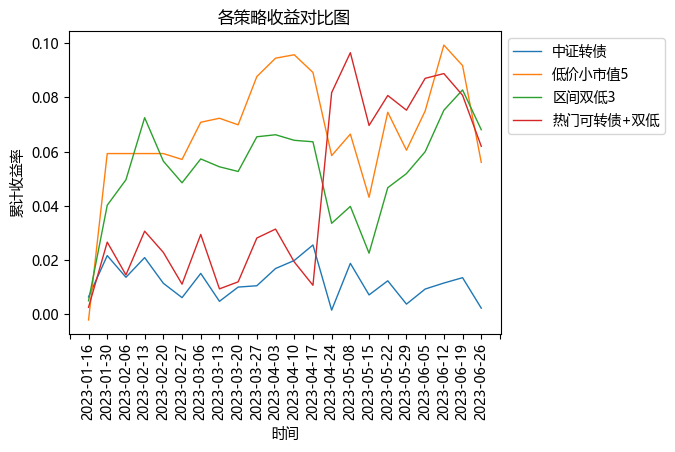

<Figure size 48000x18000 with 0 Axes>

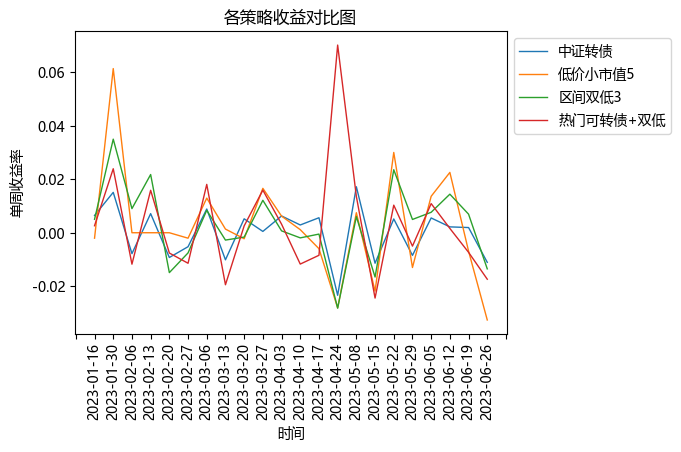

程序运行时间：66.92秒


In [29]:
# 跑1个回测周期,获得多个策略的单周收益率、累计收益率对比图
# 根据需要更改test_day_list回测周期，names策略

test_day_list = [('2022-07-01','2022-12-31'), ('2023-01-01','2023-06-30')]

"""
需要哪些策略的收益对比图，就放进哪些，这样跑的速度快并且结果清晰
names = ['低价小市值5（全量数据DTBS，用于回测）.xlsx', 
         '高ytm（全量数据DTBS，用于回测）.xlsx', 
         '区间双低3（全量数据DTBS，用于回测）.xlsx', 
         '双低5（全量数据DTBS，用于回测）.xlsx', 
         '小市值3双低5（全量数据DTBS，用于回测）.xlsx',
         '热门可转债+双低（全量数据DTBS，用于回测）.xlsx']
"""

names = ['低价小市值5（全量数据DTBS，用于回测）.xlsx',
         '区间双低3（全量数据DTBS，用于回测）.xlsx',
         '热门可转债+双低（全量数据DTBS，用于回测）.xlsx']


set_which_day = 'mon'
    
start_time = time.time()

for start_day,end_day in test_day_list:    
    profit_dict = {}   
    for name in names: 
              
        # 获得标准化持仓字典        
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)

        # 获得收益率曲线列表    
        profit = get_weekly_return(trade_dates_list,D_DF,A_DF,10000000,my_position,my_current_flag=1)

        # 获取各类收益率
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = get_all_profit(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 1)
        
        strategy_name = str(name[ : name.index('（')])
        profit_dict[strategy_name] = {'weekly_return' : weekly_return, 
                                      'cumulative_return' : cumulative_return}
        
    display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = '各策略收益对比图', tick_spacing = 1) 
    
end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")


 2021-04-26 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}

 2021-04-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4472.09 , 持仓明细字典: {'123061.SZ': 19300, '128056.SZ': 19300, '123102.SZ': 19300, '128074.SZ': 19300, '123093.SZ': 19300}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-05-06 : 今日是非


 2021-06-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3567.25 , 持仓明细字典: {'123011.SZ': 20280, '113601.SH': 20280, '113566.SH': 20280, '113624.SH': 20280, '123080.SZ': 20280}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-06-28 : 今日是调仓日
换仓前, 账户内剩余现金: 3567.25 , 持仓明细字典: {'123011.SZ': 20280, '113601.SH': 20280, '113566.SH': 20280, '113624.SH': 20280, '123080.SZ': 20280}
等份额调仓
换仓后, 账户内剩余现金: 1559.26 , 持仓明细字典: {'113573.SH': 20900, '123023.SZ': 20900, '128118.SZ': 20900, '128069.SZ': 20900, '123080.SZ': 20900}

 2021-06-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1559.26 , 持仓明细字典: {'113573.SH': 20900, '123023.SZ': 20900, '128118.SZ': 20900, '128069.SZ': 20900, '123080.SZ': 20900}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-06-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1559.26 , 持仓明细字典: {'113573.SH': 20900, '123023.SZ': 20900, '128118.SZ': 20900, '128069.SZ': 20900, '123080.SZ': 20900}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-07-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1559.26 , 持仓明细字典: {'113573.SH': 20900, '123023.SZ': 20900, '128


 2021-08-20 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4633.1 , 持仓明细字典: {'123028.SZ': 21740, '128117.SZ': 21740, '113600.SH': 21740, '113624.SH': 21740, '128022.SZ': 21740}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-23 : 今日是调仓日
换仓前, 账户内剩余现金: 4633.1 , 持仓明细字典: {'123028.SZ': 21740, '128117.SZ': 21740, '113600.SH': 21740, '113624.SH': 21740, '128022.SZ': 21740}
等份额调仓
换仓后, 账户内剩余现金: 4885.51 , 持仓明细字典: {'123028.SZ': 21450, '113591.SH': 21450, '128074.SZ': 21450, '113624.SH': 21450, '113546.SH': 21450}

 2021-08-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4885.51 , 持仓明细字典: {'123028.SZ': 21450, '113591.SH': 21450, '128074.SZ': 21450, '113624.SH': 21450, '113546.SH': 21450}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4885.51 , 持仓明细字典: {'123028.SZ': 21450, '113591.SH': 21450, '128074.SZ': 21450, '113624.SH': 21450, '113546.SH': 21450}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4885.51 , 持仓明细字典: {'123028.SZ': 21450, '113591.SH': 21450, '12807


 2021-10-25 : 今日是调仓日
换仓前, 账户内剩余现金: 243.35 , 持仓明细字典: {'128066.SZ': 23700, '123106.SZ': 23700, '128070.SZ': 23700, '123082.SZ': 23700, '113546.SH': 23700}
等份额调仓
换仓后, 账户内剩余现金: 879.04 , 持仓明细字典: {'123056.SZ': 24340, '123126.SZ': 24340, '123093.SZ': 24340, '128074.SZ': 24340, '113628.SH': 24340}

 2021-10-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 879.04 , 持仓明细字典: {'123056.SZ': 24340, '123126.SZ': 24340, '123093.SZ': 24340, '128074.SZ': 24340, '113628.SH': 24340}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 879.04 , 持仓明细字典: {'123056.SZ': 24340, '123126.SZ': 24340, '123093.SZ': 24340, '128074.SZ': 24340, '113628.SH': 24340}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 879.04 , 持仓明细字典: {'123056.SZ': 24340, '123126.SZ': 24340, '123093.SZ': 24340, '128074.SZ': 24340, '113628.SH': 24340}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 879.04 , 持仓明细字典: {'123056.SZ': 24340, '123126.SZ': 24340, '123093.SZ


 2021-12-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 827.17 , 持仓明细字典: {'113589.SH': 26210, '113519.SH': 26210, '113601.SH': 26210, '128069.SZ': 26210, '113597.SH': 26210}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-20 : 今日是调仓日
换仓前, 账户内剩余现金: 827.17 , 持仓明细字典: {'113589.SH': 26210, '113519.SH': 26210, '113601.SH': 26210, '128069.SZ': 26210, '113597.SH': 26210}
等份额调仓
换仓后, 账户内剩余现金: 5514.07 , 持仓明细字典: {'113519.SH': 26200, '123056.SZ': 26200, '128117.SZ': 26200, '113573.SH': 26200, '128118.SZ': 26200}

 2021-12-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 5514.07 , 持仓明细字典: {'113519.SH': 26200, '123056.SZ': 26200, '128117.SZ': 26200, '113573.SH': 26200, '128118.SZ': 26200}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 5514.07 , 持仓明细字典: {'113519.SH': 26200, '123056.SZ': 26200, '128117.SZ': 26200, '113573.SH': 26200, '128118.SZ': 26200}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 5514.07 , 持仓明细字典: {'113519.SH': 26200, '123056.SZ': 26200, '12811


 2022-02-21 : 今日是调仓日
换仓前, 账户内剩余现金: 21.43 , 持仓明细字典: {'128138.SZ': 44560, '128118.SZ': 44560, '113584.SH': 44560}
等份额调仓
换仓后, 账户内剩余现金: 1451.82 , 持仓明细字典: {'113569.SH': 26100, '123093.SZ': 26100, '113573.SH': 26100, '123065.SZ': 26100, '113566.SH': 26100}

 2022-02-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1451.82 , 持仓明细字典: {'113569.SH': 26100, '123093.SZ': 26100, '113573.SH': 26100, '123065.SZ': 26100, '113566.SH': 26100}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1451.82 , 持仓明细字典: {'113569.SH': 26100, '123093.SZ': 26100, '113573.SH': 26100, '123065.SZ': 26100, '113566.SH': 26100}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1451.82 , 持仓明细字典: {'113569.SH': 26100, '123093.SZ': 26100, '113573.SH': 26100, '123065.SZ': 26100, '113566.SH': 26100}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1451.82 , 持仓明细字典: {'113569.SH': 26100, '123093.SZ': 26100, '113573.SH': 26100, '123065.SZ': 26100, '11356


 2022-04-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1255.54 , 持仓明细字典: {'113573.SH': 26730, '128074.SZ': 26730, '123093.SZ': 26730, '113628.SH': 26730, '113594.SH': 26730}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-18 : 今日是调仓日
换仓前, 账户内剩余现金: 1255.54 , 持仓明细字典: {'113573.SH': 26730, '128074.SZ': 26730, '123093.SZ': 26730, '113628.SH': 26730, '113594.SH': 26730}
等份额调仓
换仓后, 账户内剩余现金: 1488.77 , 持仓明细字典: {'113569.SH': 27590, '128074.SZ': 27590, '113628.SH': 27590, '113584.SH': 27590, '123088.SZ': 27590}


<Figure size 48000x18000 with 0 Axes>

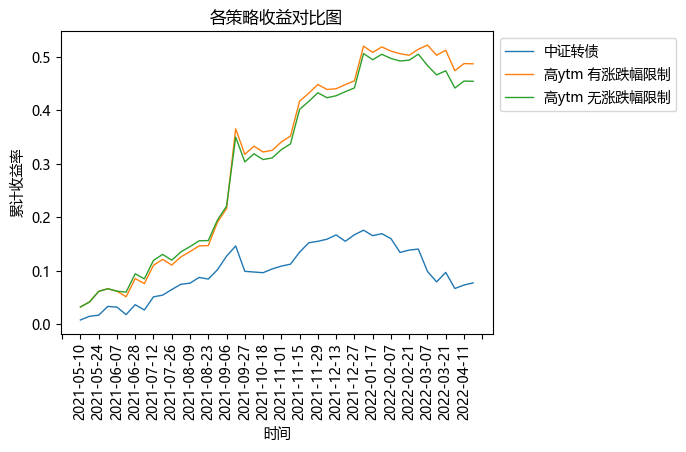

<Figure size 48000x18000 with 0 Axes>

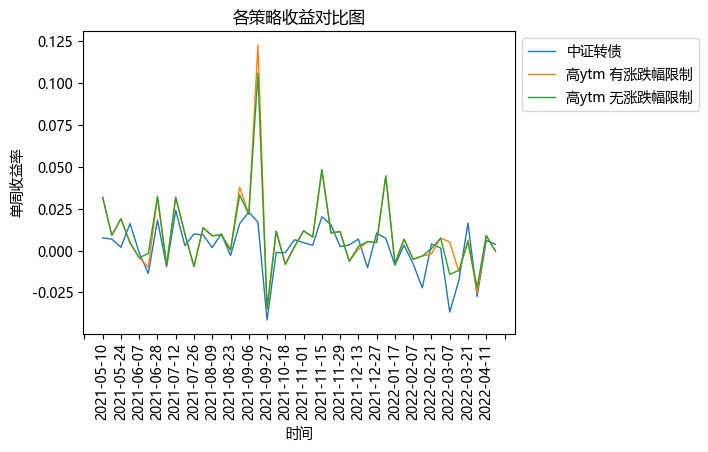


 2022-04-25 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}

 2022-04-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-05-05 : 今日是非调仓日，监


 2022-06-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1230.38 , 持仓明细字典: {'128138.SZ': 18930, '113604.SH': 18930, '128117.SZ': 18930, '113573.SH': 18930, '128125.SZ': 18930}
128117.SZ ：突破最大涨幅限制，需要止盈。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 2799.62 , 持仓明细字典: {'128138.SZ': 25780, '113604.SH': 25780, '113573.SH': 25780, '128125.SZ': 25780}

 2022-06-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 2799.62 , 持仓明细字典: {'128138.SZ': 25780, '113604.SH': 25780, '113573.SH': 25780, '128125.SZ': 25780}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-06-27 : 今日是调仓日
换仓前, 账户内剩余现金: 2799.62 , 持仓明细字典: {'128138.SZ': 25780, '113604.SH': 25780, '113573.SH': 25780, '128125.SZ': 25780}
等份额调仓
换仓后, 账户内剩余现金: 3580.46 , 持仓明细字典: {'128138.SZ': 20620, '113604.SH': 20620, '128074.SZ': 20620, '123126.SZ': 20620, '128118.SZ': 20620}

 2022-06-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3580.46 , 持仓明细字典: {'128138.SZ': 20620, '113604.SH': 20620, '128074.SZ': 20620, '123126.SZ': 20620, '128118.SZ': 20620}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-06-29 : 今


 2022-08-18 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3086.09 , 持仓明细字典: {'128074.SZ': 21060, '128116.SZ': 21060, '128118.SZ': 21060, '128085.SZ': 21060, '118004.SH': 21060}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-19 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 3086.09 , 持仓明细字典: {'128074.SZ': 21060, '128116.SZ': 21060, '128118.SZ': 21060, '128085.SZ': 21060, '118004.SH': 21060}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-22 : 今日是调仓日
换仓前, 账户内剩余现金: 3086.09 , 持仓明细字典: {'128074.SZ': 21060, '128116.SZ': 21060, '128118.SZ': 21060, '128085.SZ': 21060, '118004.SH': 21060}
等份额调仓
换仓后, 账户内剩余现金: 405.52 , 持仓明细字典: {'113589.SH': 21240, '113569.SH': 21240, '123126.SZ': 21240, '128085.SZ': 21240, '123093.SZ': 21240}

 2022-08-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 405.52 , 持仓明细字典: {'113589.SH': 21240, '113569.SH': 21240, '123126.SZ': 21240, '128085.SZ': 21240, '123093.SZ': 21240}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 405.52 , 持仓明细字典: {'113589.SH': 21240, '113569.SH': 21240, '123126


 2022-10-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1670.49 , 持仓明细字典: {'128085.SZ': 21530, '113625.SH': 21530, '113604.SH': 21530, '128116.SZ': 21530, '127055.SZ': 21530}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1670.49 , 持仓明细字典: {'128085.SZ': 21530, '113625.SH': 21530, '113604.SH': 21530, '128116.SZ': 21530, '127055.SZ': 21530}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1670.49 , 持仓明细字典: {'128085.SZ': 21530, '113625.SH': 21530, '113604.SH': 21530, '128116.SZ': 21530, '127055.SZ': 21530}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1670.49 , 持仓明细字典: {'128085.SZ': 21530, '113625.SH': 21530, '113604.SH': 21530, '128116.SZ': 21530, '127055.SZ': 21530}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-31 : 今日是调仓日
换仓前, 账户内剩余现金: 1670.49 , 持仓明细字典: {'128085.SZ': 21530, '113625.SH': 21530, '113604.SH': 21530, '128116.SZ': 21530, '127055.SZ': 21530}
等份额调仓
换仓后, 账户内剩余现金: 3674.85 , 持仓明细字典: {'128085.SZ': 21130, '1


 2022-12-19 : 今日是调仓日
换仓前, 账户内剩余现金: 2140.24 , 持仓明细字典: {'128085.SZ': 21120, '128074.SZ': 21120, '123093.SZ': 21120, '123039.SZ': 21120, '123116.SZ': 21120}
等份额调仓
换仓后, 账户内剩余现金: 4128.75 , 持仓明细字典: {'128085.SZ': 21210, '123063.SZ': 21210, '123093.SZ': 21210, '113601.SH': 21210, '113639.SH': 21210}

 2022-12-20 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4128.75 , 持仓明细字典: {'128085.SZ': 21210, '123063.SZ': 21210, '123093.SZ': 21210, '113601.SH': 21210, '113639.SH': 21210}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4128.75 , 持仓明细字典: {'128085.SZ': 21210, '123063.SZ': 21210, '123093.SZ': 21210, '113601.SH': 21210, '113639.SH': 21210}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4128.75 , 持仓明细字典: {'128085.SZ': 21210, '123063.SZ': 21210, '123093.SZ': 21210, '113601.SH': 21210, '113639.SH': 21210}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 4128.75 , 持仓明细字典: {'128085.SZ': 21210, '123063.SZ': 21210, '123


 2023-02-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 226.22 , 持仓明细字典: {'128085.SZ': 22240, '113569.SH': 22240, '113601.SH': 22240, '123106.SZ': 22240, '128116.SZ': 22240}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 226.22 , 持仓明细字典: {'128085.SZ': 22240, '113569.SH': 22240, '113601.SH': 22240, '123106.SZ': 22240, '128116.SZ': 22240}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-27 : 今日是调仓日
换仓前, 账户内剩余现金: 226.22 , 持仓明细字典: {'128085.SZ': 22240, '113569.SH': 22240, '113601.SH': 22240, '123106.SZ': 22240, '128116.SZ': 22240}
等份额调仓
换仓后, 账户内剩余现金: 1578.66 , 持仓明细字典: {'128085.SZ': 21980, '113610.SH': 21980, '128074.SZ': 21980, '128116.SZ': 21980, '113606.SH': 21980}

 2023-02-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1578.66 , 持仓明细字典: {'128085.SZ': 21980, '113610.SH': 21980, '128074.SZ': 21980, '128116.SZ': 21980, '113606.SH': 21980}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1578.66 , 持仓明细字典: {'128085.SZ': 21980, '113610.SH': 21980, '128074

<Figure size 48000x18000 with 0 Axes>

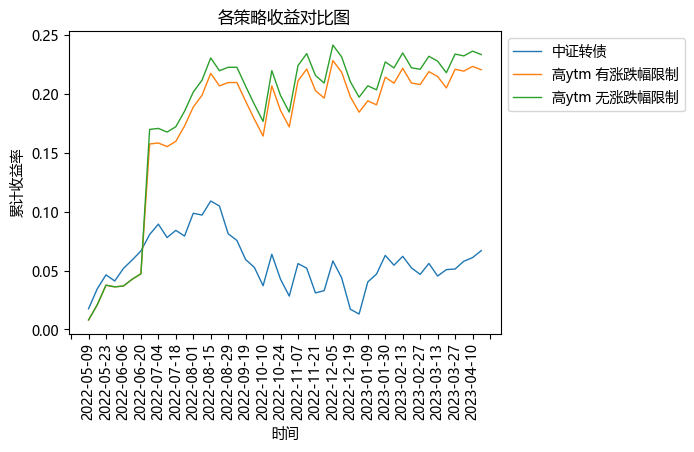

<Figure size 48000x18000 with 0 Axes>

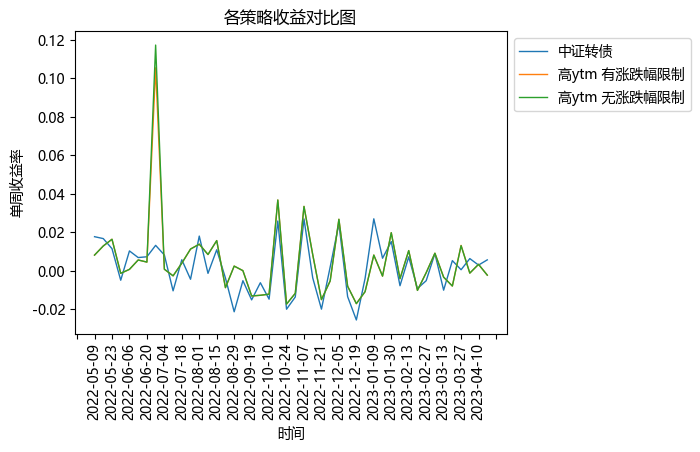

程序运行时间：49.56秒


In [19]:
# 对比设/不设涨跌幅限制的收益率曲线

test_day_list = [('2021-04-20','2022-04-19'), ('2022-04-20','2023-04-19')]

names = ['高ytm（全量数据DTBS，用于回测）.xlsx']

set_which_day = 'mon'

start_time = time.time()
          
for start_day,end_day in test_day_list:    
    profit_dict = {}   
    for name in names: 
        
        strategy_name = str(name[ : name.index('（')])
              
        # 获得标准化持仓字典
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)

        # 获得收益率曲线列表    
        profit = get_weekly_return(trade_dates_list,D_DF,A_DF,10000000,my_position,my_current_flag=1)

        # 获取各类收益率
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = get_all_profit(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 1)
        
        
        profit_dict[strategy_name + ' 有涨跌幅限制'] = {'weekly_return' : weekly_return, 
                                      'cumulative_return' : cumulative_return}
        
        # 获得收益率曲线列表    
        profit = get_period_profit(trade_dates_list, my_position, A_DF)

        # 获取各类收益率
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = get_all_profit(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 1)
        
        profit_dict[strategy_name + ' 无涨跌幅限制'] = {'weekly_return' : weekly_return, 
                                      'cumulative_return' : cumulative_return}
        
    display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = '各策略收益对比图', tick_spacing = 2)

end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")
